In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
import ast

import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [2]:
dftrain = pd.read_pickle('data_train.p')
dfval = pd.read_pickle('data_val.p')
dftest = pd.read_pickle('data_test.p')

In [3]:
dftrain.columns

Index(['business_id', 'date', 'stars', 'text', 'user_id', 'cos_sim_all',
       'cos_sim_noun', 'cos_sim_adj', 'cos_sim_verb', 'count_review_bus',
       'avg_stars_bus', 'count_funny_bus', 'count_cool_bus',
       'count_useful_bus', 'avg_sent_score_compound_bus',
       'avg_sent_score_net_bus', 'avg_review_length_bus', 'avg_punc_count_bus',
       'avg_word_len_bus', 'count_review_user', 'avg_stars_user',
       'count_funny_user', 'count_cool_user', 'count_useful_user',
       'avg_sent_score_compound_user', 'avg_sent_score_net_user',
       'avg_review_length_user', 'avg_punc_count_user', 'avg_word_len_user',
       'RestaurantsPriceRange2', 'Alcohol', 'BusinessAcceptsCreditCards',
       'GoodForKids', 'OutdoorSeating', 'RestaurantsAttire',
       'RestaurantsGoodForGroups', 'RestaurantsTableService',
       'RestaurantsTakeOut', 'BikeParking', 'Caters', 'DogsAllowed',
       'GoodForMeal', 'HasTV', 'NoiseLevel', 'RestaurantsDelivery',
       'RestaurantsReservations', 'Wheelchai

In [4]:
extra_columns = ['business_id', 
                 'date', 
                 'text', 
                 'user_id', 
                 'GoodForMeal', 
                 'Music',
                 'BestNights',
                 'HairSpecializesIn',
                 'DietaryRestrictions']
dummy_cols = ['NoiseLevel', 'WiFi', 'Smoking', 'AgesAllowed']
target = 'stars'

In [40]:
def data_to_model(raw_data, dummy_cols, normalize_using=None):
    df_X = raw_data.drop(extra_columns + dummy_cols + [target], axis=1)
    if normalize_using is not None:
        df_norm = normalize_using.drop(extra_columns + dummy_cols + [target], axis=1)
    df_y = raw_data[target]
    
    for dummy_col in dummy_cols:
        df_dummy = pd.get_dummies(raw_data[dummy_col], prefix=dummy_col)
        df_X = df_X.join(df_dummy)
        if normalize_using is not None:
            norm_dummy = pd.get_dummies(normalize_using[dummy_col], prefix=dummy_col)
            df_norm = df_norm.join(norm_dummy)
        
    if normalize_using is None:
        df_norm = df_X
        
    normalize(df_X, df_norm)
    return df_X.fillna(0), df_y


def normalize(df_X, normalize_using):
    # memory saving normalization
    for col in df_X.columns:
        # print('normalizing %s' % col)
        norm_mean = np.mean(normalize_using[col].astype(float))
        norm_std = np.std(normalize_using[col].astype(float))
        df_X[col] = (df_X[col].astype(float) - norm_mean) / norm_std

In [41]:
df_X, df_y = data_to_model(dftrain, dummy_cols, dftrain)
df_Xval, df_yval = data_to_model(dfval, dummy_cols, dftrain)
df_Xtest, df_ytest = data_to_model(dftest, dummy_cols, dftrain)

In [42]:
X = df_X.values
y = df_y.values

### Models

In [71]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X, y)
lin_r = LinearRegression().fit(X, y)

### Validation Data

In [72]:
# filling missing dummies with 0
for col in df_X.columns:
    if col not in df_Xval.columns:
        df_Xval[col] = 0
        df_Xtest[col] = 0

In [74]:
preds_lr = lr.predict(df_Xval.values)
preds_lin = lin_r.predict(df_Xval.values)

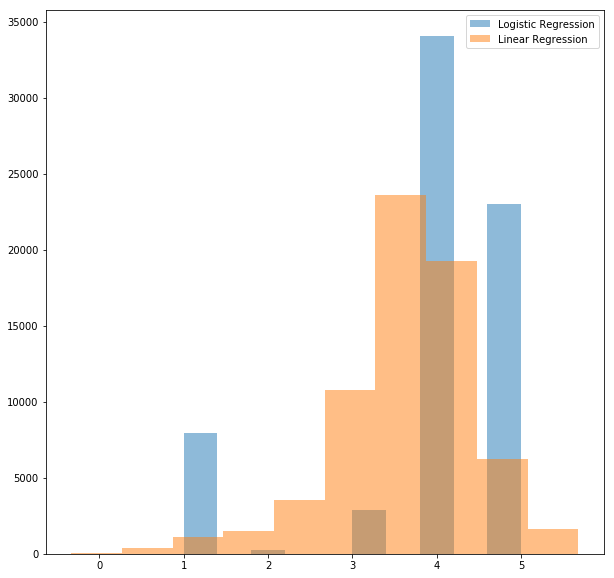

In [79]:
plt.figure(figsize=(10, 10))
plt.hist(preds, label='Logistic Regression', alpha=0.5)
plt.hist(preds_lin, label='Linear Regression', alpha=0.5)
plt.legend()
plt.show()

In [80]:
lr.score(df_Xval, df_yval)

0.46235390849826746

In [81]:
lin_r.score(df_Xval, df_yval)

0.3796052246128903

In [82]:
def mse(preds, truths):
    assert len(preds) == len(truths)
    sse = 0.
    for i in range(len(preds)):
        sse += (preds[i] - truths[i]) ** 2
    return sse / len(preds)

In [83]:
mse(preds, df_yval)

1.5723556704058261

In [84]:
mse(preds_lin, df_yval)

1.0970392799542021

### To Do: Cross Validation